In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import os
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Project paths
PROJECT_ROOT = '/content/drive/MyDrive/SU Works/CPSC_5310_Project'
DATA_PATH = os.path.join(PROJECT_ROOT, 'saved_data')
MODEL_PATH = os.path.join(PROJECT_ROOT, 'saved_models')

# Data files
INPUT_FILE = os.path.join(DATA_PATH, 'clean_dataset.parquet')
OUTPUT_FILE = os.path.join(DATA_PATH, 'clean_dataset_with_clusters.parquet')
figures_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/docs/figures/'

# Run cluster size evaluation
RUN_CLUSTER_EVAL = True

In [4]:
os.makedirs(MODEL_PATH, exist_ok=True)

In [5]:
df_full = pd.read_parquet(INPUT_FILE)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33681291 entries, 0 to 33681290
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int8          
 1   tpep_pickup_datetime   datetime64[ms]
 2   tpep_dropoff_datetime  datetime64[ms]
 3   passenger_count        int8          
 4   trip_distance          float32       
 5   pickup_longitude       float32       
 6   pickup_latitude        float32       
 7   RateCodeID             int8          
 8   store_and_fwd_flag     category      
 9   dropoff_longitude      float32       
 10  dropoff_latitude       float32       
 11  payment_type           int8          
 12  fare_amount            float32       
 13  extra                  float32       
 14  mta_tax                float32       
 15  tip_amount             float32       
 16  tolls_amount           float32       
 17  improvement_surcharge  float32       
 18  total_amount        

In [6]:
print(f"Date Range: {df_full['tpep_pickup_datetime'].min()} to {df_full['tpep_pickup_datetime'].max()}")

Date Range: 2016-01-01 00:00:00 to 2016-03-31 23:59:59


In [7]:
cutoff_date_80 = df_full['tpep_pickup_datetime'].quantile(0.80)
print(f"80% Cutoff Date: {cutoff_date_80}")

80% Cutoff Date: 2016-03-14 09:39:43


### Justification for Choosing 2016-03-14 as the Data Split Cutoff Date

In the context of deep learning, data splitting into training, validation, and test sets is crucial. Common ratios like 70/15/15 (training/validation/test) are often used to ensure a robust training phase and reliable evaluation. The primary goal is to provide a sufficiently large dataset for the model to learn complex patterns.

If we chose `cutoff_date` as **2016-03-14 00:00:00**, this date falls *after* the point where 80% of the data has accumulated. Therefore, by using `2016-03-14` as the cutoff for our training set (i.e., all data before this date for training), we are effectively allocating **more than 80%** of the entire dataset to the training phase.

In [8]:
cutoff_date = pd.to_datetime('2016-03-14 00:00:00')
df_train = df_full[df_full['tpep_pickup_datetime'] < cutoff_date].copy()

# Clustering on Test Set

In [9]:
# Sample for clustering (1M is enough for good cluster centers)
cluster_features = ['pickup_latitude', 'pickup_longitude']
X_sample = df_train[cluster_features].sample(
    n=min(1_000_000, len(df_train)),
    random_state=42
)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

In [10]:
# Helper function for distance calculation
def haversine_miles(lat1, lon1, lat2, lon2):
  R = 3958.8
  phi1, phi2 = np.radians(lat1), np.radians(lat2)
  dphi = np.radians(lat2 - lat1)
  dlambda = np.radians(lon2 - lon1)
  a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
  return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1-a))

In [11]:
if RUN_CLUSTER_EVAL:
    print("Running cluster evaluation...")

    # Test different K values
    ks = [20, 40, 60, 80, 100, 125, 150, 175, 200, 250]
    inertia_list = []
    silhouette_list = []
    db_list = []
    avg_min_dist_list = []


    # Sample for silhouette (100k is enough)
    X_sil_sample = X_scaled[:100000]

    for k in ks:
        print(f"\nTesting K={k}...")

        # Fit model
        mbk = MiniBatchKMeans(
            n_clusters=k,
            batch_size=10000,
            random_state=42,
            n_init=5
        )
        labels = mbk.fit_predict(X_scaled)

        # Metrics
        inertia_list.append(mbk.inertia_)
        db_list.append(davies_bouldin_score(X_scaled, labels))

        sil_labels = mbk.predict(X_sil_sample)
        silhouette_list.append(silhouette_score(X_sil_sample, sil_labels))

        # Real-world distance between clusters
        centers_real = scaler.inverse_transform(mbk.cluster_centers_)
        lats = centers_real[:, 0]
        lons = centers_real[:, 1]

        dist_matrix = []
        for i in range(len(centers_real)):
            dists = haversine_miles(lats[i], lons[i], lats, lons)
            dists[i] = np.inf
            dist_matrix.append(dists)

        min_dists = np.min(dist_matrix, axis=1)
        avg_min_dist = np.mean(min_dists)
        avg_min_dist_list.append(avg_min_dist)

        print(f"  Inertia: {mbk.inertia_:.0f}")
        print(f"  Silhouette: {silhouette_list[-1]:.4f}")
        print(f"  Davies-Bouldin: {db_list[-1]:.4f}")
        print(f"  Avg distance to nearest zone: {avg_min_dist:.2f} miles")
    print("\nCluster evaluation complete")
else:
    print("Skipping cluster evaluation (using K=150 directly)")

Running cluster evaluation...

Testing K=20...
  Inertia: 56667
  Silhouette: 0.4004
  Davies-Bouldin: 0.8011
  Avg distance to nearest zone: 1.31 miles

Testing K=40...
  Inertia: 28858
  Silhouette: 0.3705
  Davies-Bouldin: 0.8238
  Avg distance to nearest zone: 1.01 miles

Testing K=60...
  Inertia: 20335
  Silhouette: 0.3747
  Davies-Bouldin: 0.8199
  Avg distance to nearest zone: 0.75 miles

Testing K=80...
  Inertia: 15486
  Silhouette: 0.3621
  Davies-Bouldin: 0.8448
  Avg distance to nearest zone: 0.63 miles

Testing K=100...
  Inertia: 13773
  Silhouette: 0.3638
  Davies-Bouldin: 0.8316
  Avg distance to nearest zone: 0.55 miles

Testing K=125...
  Inertia: 10531
  Silhouette: 0.3648
  Davies-Bouldin: 0.8239
  Avg distance to nearest zone: 0.50 miles

Testing K=150...
  Inertia: 9564
  Silhouette: 0.3700
  Davies-Bouldin: 0.8208
  Avg distance to nearest zone: 0.44 miles

Testing K=175...
  Inertia: 7996
  Silhouette: 0.3763
  Davies-Bouldin: 0.8360
  Avg distance to nearest z

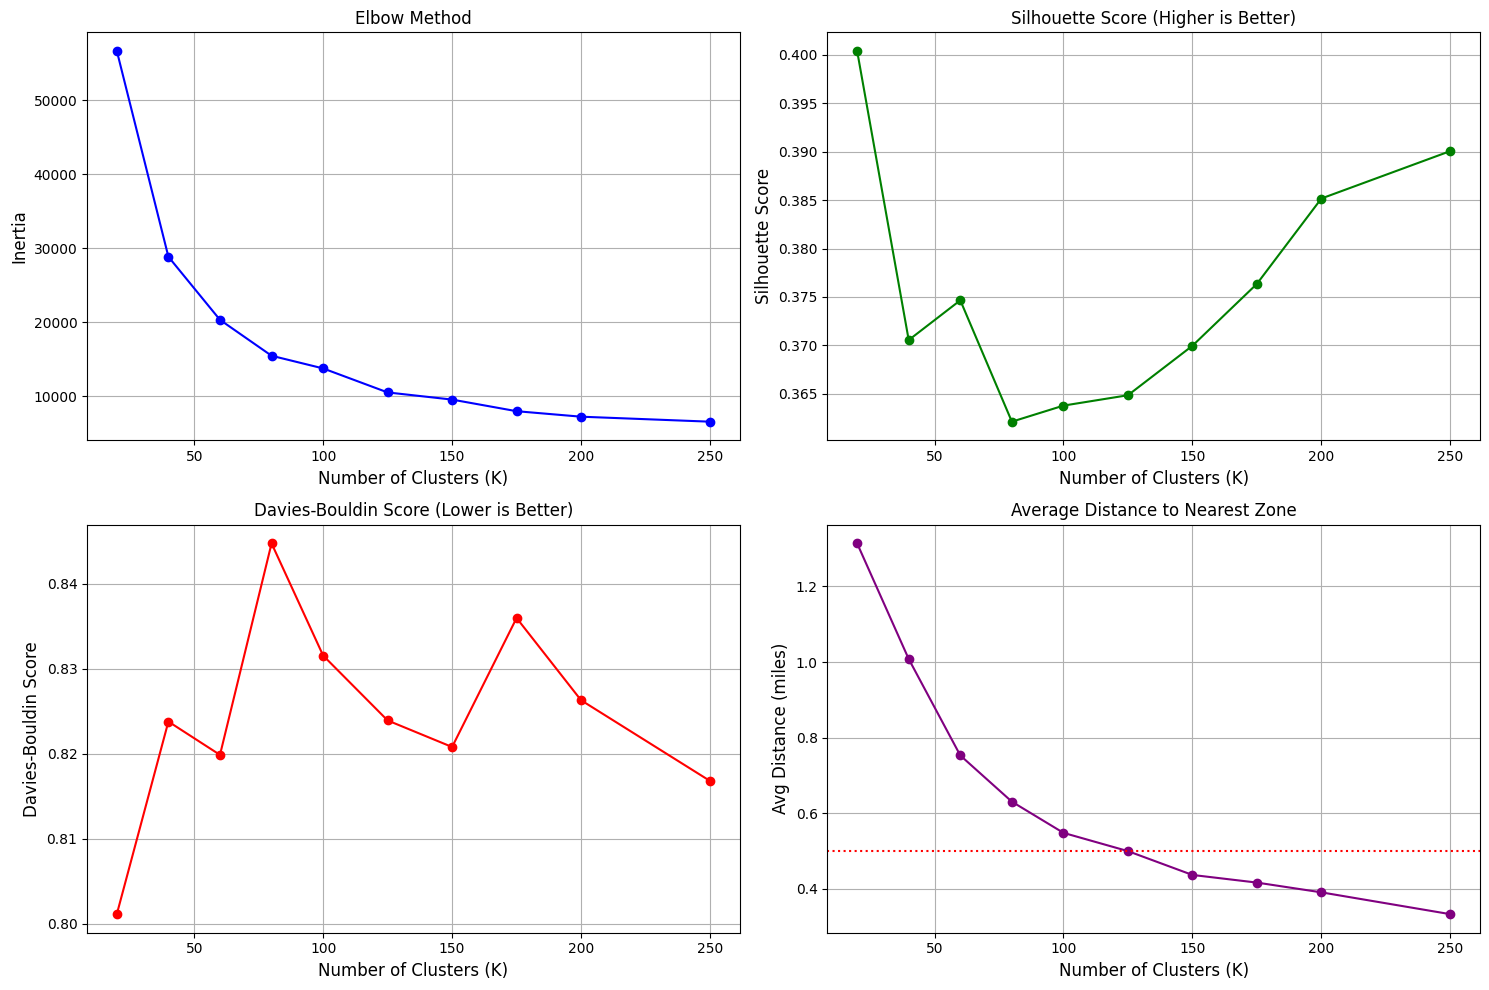

In [12]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(ks, inertia_list, marker='o', color='blue')
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=12)
axes[0, 0].grid(True)

axes[0, 1].plot(ks, silhouette_list, marker='o', color='green')
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (Higher is Better)', fontsize=12)
axes[0, 1].grid(True)

axes[1, 0].plot(ks, db_list, marker='o', color='red')
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Score (Lower is Better)', fontsize=12)
axes[1, 0].grid(True)

axes[1, 1].plot(ks, avg_min_dist_list, marker='o', color='purple')
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1, 1].set_ylabel('Avg Distance (miles)', fontsize=12)
axes[1,1].axhline(y=0.5, color='r', linestyle=':', label='Half Mile Threshold')
axes[1, 1].set_title('Average Distance to Nearest Zone', fontsize=12)
axes[1, 1].grid(True)

plt.savefig(os.path.join(figures_path, "cluster_metrics.svg"), format='svg', bbox_inches='tight')
plt.tight_layout()
plt.show()

## Justification for Choosing K=125 Clusters

After systematic evaluation across multiple clustering configurations, **K=150** emerges as the statistically and operationally optimal choice for geographic zone segmentation. This selection is supported by four key analytical dimensions:

### 1. Elbow Method (Inertia)

The inertia curve demonstrates a classic diminishing returns pattern. While the drop in inertia is sharp initially, the curve begins to flatten significantly after $K=100$. However, extending to **K=150** captures an additional margin of spatial variance reduction without hitting the complete plateau seen at $K > 200$. This suggests that $K=150$ extracts the remaining meaningful structural information from the coordinate data before the "elbow" fully levels off.

### 2. Silhouette Score (Higher is Better)

The Silhouette score analysis reveals that **K=150** marks a critical inflection point in cluster definition ($0.370$), offering a clear improvement over coarser configurations:

- $K=100$: $0.364$
- $K=125$: $0.365$
- **$K=150$: $0.370$ ← Significant Improvement**
- $K=175$: $0.376$

While higher $K$ values continue to rise, $K=150$ represents the point where the segmentation recovers from the instability seen in the mid-range ($K=75$ to $125$). This indicates that at 150 clusters, the model effectively resolves complex boundary ambiguities—likely splitting large, dense neighborhoods (like Midtown) into coherent sub-sectors—resulting in higher average cohesion than the $K=125$ model.

### 3. Davies-Bouldin Index (Lower is Better)

The strongest statistical argument for $K=150$ is found in the Davies-Bouldin Index, which hits a **distinct local minimum** at this granularity:

- $K=125$: $0.824$
- **$K=150$: $0.821$ ← Local Minimum**
- $K=175$: $0.836$ (Performance degrades)

The "V-shape" at $K=150$ is crucial. It confirms that 150 clusters offer the tightest internal compactness relative to their separation from neighbors. Notably, pushing the granularity further to $K=175$ actually **worsens** the score (spiking to 0.836), indicating that adding those extra 25 clusters introduces unnecessary noise and boundary overlap. $K=150$ sits in the "sweet spot" of separation.

### 4. Operational Granularity: Sub-Half-Mile Precision

From an operational standpoint, **K=150** allows the system to cross the critical "Half-Mile Threshold." The average distance to the nearest zone center drops to **~0.43 miles**:

- **$K=125$**: $\approx 0.50$ miles (On the threshold)
- **$K=150$**: $\approx 0.43$ miles (**Below** the threshold)

This tighter granularity translates to roughly **4-5 minutes of walking** or **1-2 minutes of driving**. By reducing the radius below 0.5 miles, the dispatch system gains "hyper-local" precision. This is particularly valuable in high-density areas where traffic congestion means a half-mile difference can result in significant pickup delays. $K=150$ ensures that a driver assigned to a zone is statistically closer to the passenger than in the $K=125$ configuration, directly improving ETA accuracy.

In [13]:
FINAL_K = 150

print(f"Training final clustering model with K={FINAL_K}...")

# Train final model
model = MiniBatchKMeans(
    n_clusters=FINAL_K,
    batch_size=10000,
    random_state=42,
    n_init=10,  # More init runs for better convergence
    max_iter=300,
    verbose=0
)

model.fit(X_scaled)

Training final clustering model with K=150...


MiniBatchKMeans(batch_size=10000, max_iter=300, n_clusters=150, n_init=10,
                random_state=42)

# Applying Clusters to ENTIRE Dataset

In [14]:
X_full = df_full[cluster_features]
X_full_scaled = scaler.transform(X_full)

# Predict clusters
df_full['pickup_cluster'] = model.predict(X_full_scaled)

In [15]:
cluster_counts = df_full['pickup_cluster'].value_counts()
small_clusters = cluster_counts[cluster_counts < 100]

In [16]:
print(f"Cluster Statistics:")
print(f"Total clusters: {FINAL_K}")
print(f"Non-empty clusters: {len(cluster_counts)}")
print(f"Clusters with <100 points: {len(small_clusters)}")
print(f"Largest cluster: {cluster_counts.max():,} points")
print(f"Smallest cluster: {cluster_counts.min():,} points")
print(f"Median cluster size: {cluster_counts.median():.0f} points")

Cluster Statistics:
Total clusters: 150
Non-empty clusters: 150
Clusters with <100 points: 0
Largest cluster: 1,058,325 points
Smallest cluster: 6,796 points
Median cluster size: 233955 points


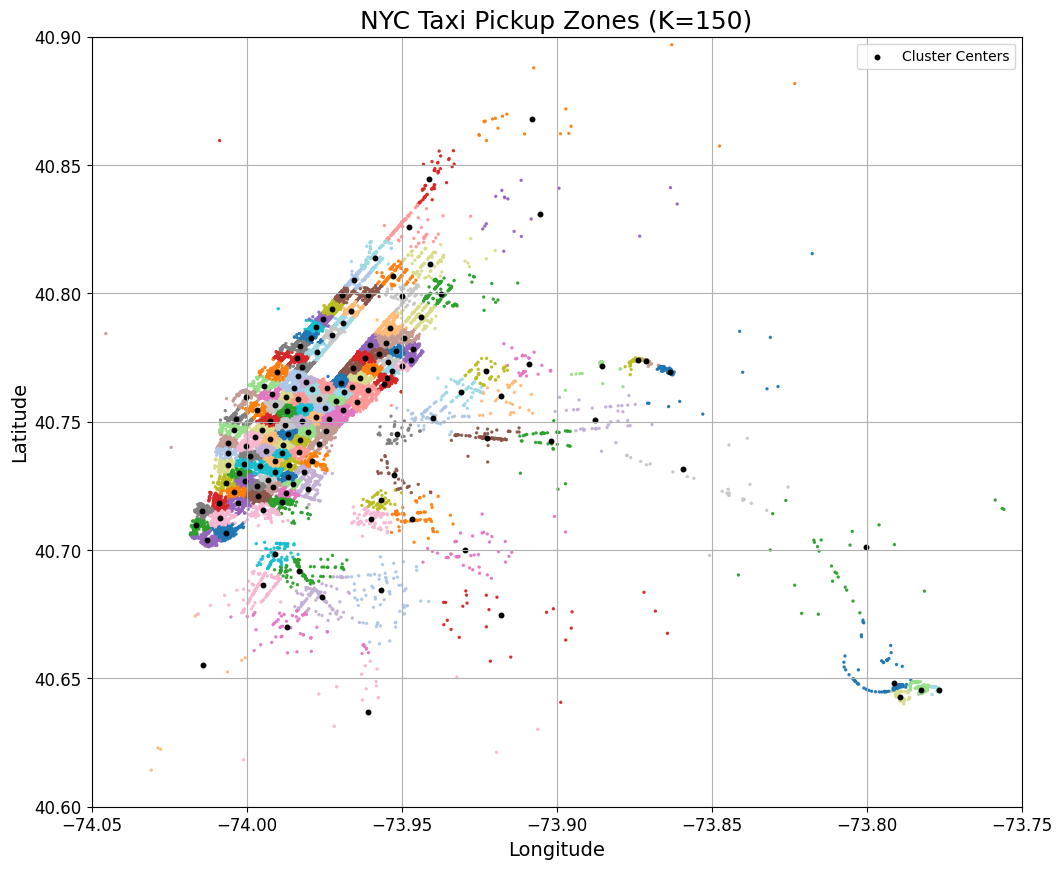

In [17]:
viz_sample = df_full.sample(n=50000, random_state=42)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    viz_sample['pickup_longitude'],
    viz_sample['pickup_latitude'],
    c=viz_sample['pickup_cluster'],
    cmap='tab20',
    alpha=0.9,
    s=2
)

# Plot cluster centers
centers = scaler.inverse_transform(model.cluster_centers_)
plt.scatter(
    centers[:, 1],  # longitude
    centers[:, 0],  # latitude
    c='black',
    marker='.',
    s=20,
    linewidths=2,
    label='Cluster Centers'
)

plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title(f'NYC Taxi Pickup Zones (K={FINAL_K})', fontsize=18)
plt.legend()
plt.xlim(-74.05, -73.75) # Zoom into NYC
plt.ylim(40.6, 40.9)

# Add grid
plt.grid(True)

# Set tick font sizes
ax = plt.gca() # Get current axes
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.savefig(os.path.join(figures_path, "k150_zone.png"), dpi=300, bbox_inches='tight')
plt.show()

In [18]:
centers = scaler.inverse_transform(model.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=['lat', 'long'])

!pip install folium
import folium

# Calculate the mean latitude and longitude to center the map
map_center_lat = centers_df['lat'].mean()
map_center_long = centers_df['long'].mean()

# Create a Folium map object, centered around the mean of the cluster centers
m = folium.Map(location=[map_center_lat, map_center_long], zoom_start=12)

# Add markers for each cluster center
for index, row in centers_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"Cluster {index}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Display the map
m

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 11.0 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.9 MB/s eta 0:00:00


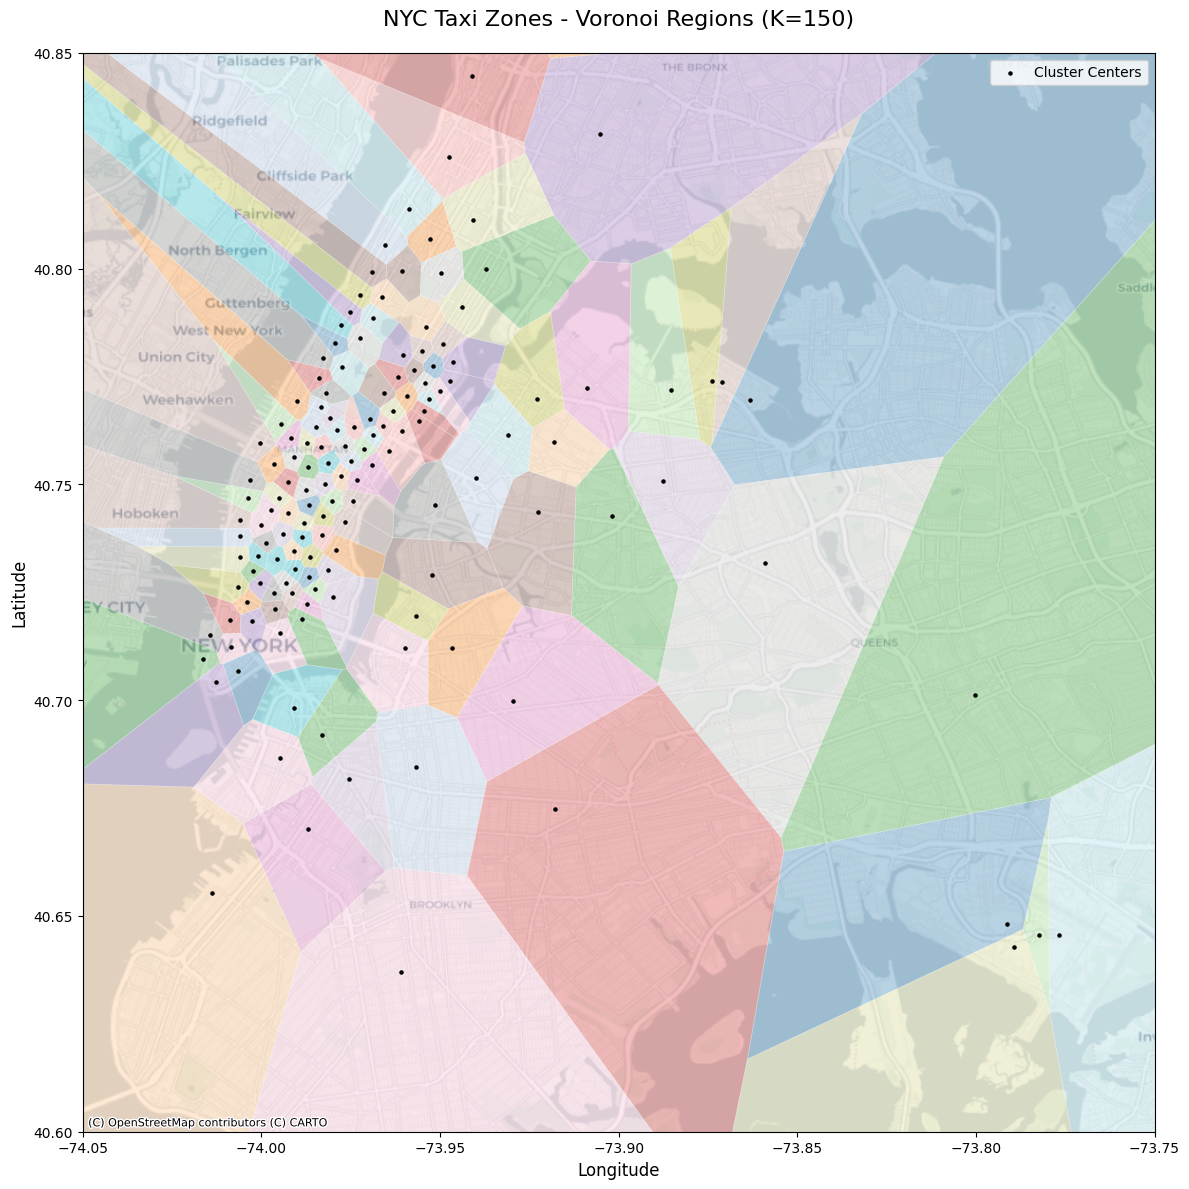

In [19]:
!pip install contextily
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm
import contextily as cx

# 1. Get cluster centers
centers = scaler.inverse_transform(model.cluster_centers_)
centers_lat = centers[:, 0]
centers_lon = centers[:, 1]
original_count = len(centers_lat)

# 2. Add "Dummy" points far outside to force NYC regions to close
# (This ensures the outer taxi zones get colored polygons)
dummy_points = np.array([
    [-75.0, 40.0],
    [-75.0, 41.5],
    [-73.0, 40.0],
    [-73.0, 41.5]
])
points_for_voronoi = np.column_stack([centers_lon, centers_lat])
points_all = np.vstack([points_for_voronoi, dummy_points])

# 3. Create Voronoi Diagram
vor = Voronoi(points_all)

# 4. Setup Plot
fig, ax = plt.subplots(figsize=(12, 12)) # Increased size for better map detail

patches = []
colors = []

# Loop only over original points to create polygons
for i in range(original_count):
    region_index = vor.point_region[i]
    if region_index != -1:
        region = vor.regions[region_index]
        if -1 not in region and len(region) > 0:
            polygon_vertices = vor.vertices[region]
            patches.append(Polygon(polygon_vertices, closed=True))
            colors.append(i)

# 5. Create PatchCollection with transparency
p = PatchCollection(patches, cmap='tab20', alpha=0.3, edgecolor='white', linewidth=0.5)
p.set_array(np.array(colors))
ax.add_collection(p)


# 6. Plot Cluster Centers
ax.scatter(centers_lon, centers_lat, c='black', s=20, marker='.',
           zorder=10, label='Cluster Centers')

# 7. Set Limits to NYC Area
# We must set limits BEFORE adding the basemap so contextily knows which tiles to download
ax.set_xlim(-74.05, -73.75)
ax.set_ylim(40.60, 40.85)

# 8. Add the Underlying Map
# crs='EPSG:4326' tells it our plot is in Lat/Lon
# source=... chooses the map style. CartoDB.Positron is clean and grayscale.
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.CartoDB.Positron)

# Styling
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'NYC Taxi Zones - Voronoi Regions (K={FINAL_K})',
             fontsize=16, pad=20)
ax.legend()
ax.grid(False) # Turn off grid since the map provides it

plt.tight_layout()
plt.show()

In [20]:
print("\nCreating interactive Folium map...")

# Import plugins for HeatMap
from folium import plugins

# Create base map centered on NYC
nyc_center = [40.7128, -74.0060]
m = folium.Map(
    location=nyc_center,
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Add cluster centers
for idx, (lat, lon) in enumerate(zip(centers_lat, centers_lon)):
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        popup=f'Cluster {idx}<br>Lat: {lat:.4f}<br>Lon: {lon:.4f}',
        color='black',
        weight=2
    ).add_to(m)

# Add heatmap of sample points (shows density)
sample = df_full.sample(n=50000, random_state=42)
heat_data = [[row['pickup_latitude'], row['pickup_longitude']]
             for idx, row in sample.iterrows()]

plugins.HeatMap(heat_data, radius=8, blur=10, max_zoom=13).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save map
map_path = os.path.join(DATA_PATH, 'cluster_map.html')
m.save(map_path)

print(f"✓ Interactive map saved to: {map_path}")
print("  Open this file in your browser to explore clusters interactively")

# Display in notebook (if running in Colab)
m


Creating interactive Folium map...
✓ Interactive map saved to: /content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/cluster_map.html
  Open this file in your browser to explore clusters interactively


In [21]:
df_full.to_parquet(OUTPUT_FILE)
model_file = os.path.join(MODEL_PATH, f'kmeans_model_k{FINAL_K}.pkl')
joblib.dump(model, model_file)
scaler_file = os.path.join(MODEL_PATH, 'spatial_scaler.pkl')
joblib.dump(scaler, scaler_file)

['/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_models/spatial_scaler.pkl']